aggregation

In [1]:
# 合併 bureau.csv 和 average.csv(貸款狀況評分)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

head = ['userID', 'SK_ID_BUREAU', 'a', 'b', 'c',
        'CO', 'e', 'f', 'g', 'h', 'CS', 'CD', 'CL', 'd', 'CT', 'i', 'annuity']
df = pd.read_csv('./data/bureau.csv') 
bal_df = pd.read_csv('./data/average.csv')
br_df = df.copy(deep=True)
br_df.columns = head
br_df.drop(columns=['a', 'b', 'c', 'd', 'e',
                  'f', 'g', 'h', 'i', 'CL', 'CO'], inplace=True)

br_df = br_df.merge(bal_df, on='SK_ID_BUREAU', how='left')
print(br_df.head())

   userID  SK_ID_BUREAU         CS        CD               CT  annuity  \
0  215354       5714462    91323.0       0.0  Consumer credit      NaN   
1  215354       5714463   225000.0  171342.0      Credit card      NaN   
2  215354       5714464   464323.5       NaN  Consumer credit      NaN   
3  215354       5714465    90000.0       NaN      Credit card      NaN   
4  215354       5714466  2700000.0       NaN  Consumer credit      NaN   

   average  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  


In [2]:
# Credit Type 名稱冗長，重新命名
print(f"命名前一共 {len(list(set(br_df['CT'])))} 個類別")
renameDict = {'Unknown type of loan' : 'Unknown type', 'Unknown type': 'Unknown type','Loan for business development':'business development',
               'Loan for working capital replenishment':'working capital replenishment','Loan for purchase of shares (margin lending)':'purchase of shares', 
              'Consumer credit':'Consumer credit', 'Mortgage':'Mortgage', 'Real estate loan' : 'Real estate loan', 'Another type of loan':'Another type of loan',
                'Loan for the purchase of equipment' :'purchase of equipment','business development':'business development',
              'Cash loan' : 'Cash loan', 'Car loan' : 'Car loan', 'Credit card':'Credit card', 'Interbank credit':'Interbank credit', 'Mobile operator loan' : 'Mobile operator loan',
               'Cash loan (non-earmarked)':'Cash loan', 'Microloan':'Microloan', 'working capital replenishment':'working capital replenishment',
              }

br_df['CT'].replace(renameDict, inplace=True)
loanType = list(set(br_df['CT']))
print(f"命名後一共 {len(set(br_df['CT']))} 個類別")
print(loanType)

命名前一共 15 個類別
命名後一共 15 個類別
['Car loan', 'purchase of equipment', 'Interbank credit', 'Real estate loan', 'Another type of loan', 'Credit card', 'Mortgage', 'Cash loan', 'Consumer credit', 'Unknown type', 'Microloan', 'business development', 'Mobile operator loan', 'working capital replenishment', 'purchase of shares']


In [3]:
# 確認每筆貸款 ID 不重複
if len(br_df['SK_ID_BUREAU']) == len(set(br_df['SK_ID_BUREAU'])):
    print('There\'s no replication.')
else:
    print(br_df['SK_ID_BUREAU'])

There's no replication.


In [7]:
# bureau 後半段索取欄位
print(br_df.iloc[:,2:].describe())

                 CS            CD       annuity        average
count  1.716415e+06  1.458759e+06  4.896370e+05  694145.000000
mean   3.549946e+05  1.370851e+05  1.571276e+04       0.954116
std    1.149811e+06  6.774011e+05  3.258269e+05       0.251112
min    0.000000e+00 -4.705600e+06  0.000000e+00      -5.000000
25%    5.130000e+04  0.000000e+00  0.000000e+00       1.000000
50%    1.255185e+05  0.000000e+00  0.000000e+00       1.000000
75%    3.150000e+05  4.015350e+04  1.350000e+04       1.000000
max    5.850000e+08  1.701000e+08  1.184534e+08       1.000000


In [5]:
print(br_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1716428 entries, 0 to 1716427
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   userID        int64  
 1   SK_ID_BUREAU  int64  
 2   CS            float64
 3   CD            float64
 4   CT            object 
 5   annuity       float64
 6   average       float64
dtypes: float64(4), int64(2), object(1)
memory usage: 104.8+ MB
None


In [3]:
# 各欄位的正負值、零、nan 占比, eta = 2 mins
# 因不可能有負的負債 (CD)，後續會將 8418 筆調為正值
cols = ['CS','CD','annuity','average']
for col in cols:
    m = 0
    n = 0
    o = 0
    p = br_df[col].isna().sum()
    for i in range(len(br_df[col])):
        if br_df[col][i] > 0:
            n += 1
        elif br_df[col][i] < 0:
            m += 1
        else:
            o += 1
    print(f'{col} Total:{len(br_df[col])} ; 正:{n} ({round(n/(m+n+o),4)*100}%) ; 負:{m} ({round(m/(m+n+o),4)*100}%) ; 零:{o-p} ({round((o-p)/(m+n+o),4)*100}%) ; NaN:{p} ({round((p/(m+n+o)),4)*100}%)')

CS Total:1716428 ; 正:1649833 (96.12%) ; 負:0 (0.0%) ; 零:66582 (3.88%) ; NaN:13 (0.0%)
CD Total:1716428 ; 正:433907 (25.28%) ; 負:8418 (0.49%) ; 零:1016434 (59.21999999999999%) ; NaN:257669 (15.010000000000002%)
annuity Total:1716428 ; 正:232722 (13.56%) ; 負:0 (0.0%) ; 零:256915 (14.97%) ; NaN:1226791 (71.47%)
average Total:1716428 ; 正:688151 (40.089999999999996%) ; 負:4944 (0.29%) ; 零:1050 (0.06%) ; NaN:1022283 (59.56%)


In [4]:
# 各欄值多樣性
bureau_unique=(br_df.apply(lambda x:x.unique().shape[0]))
print(bureau_unique)

userID           305811
SK_ID_BUREAU    1716428
CS               236709
CD               226538
CT                   15
annuity           40322
average            3522
dtype: int64


<Axes: >

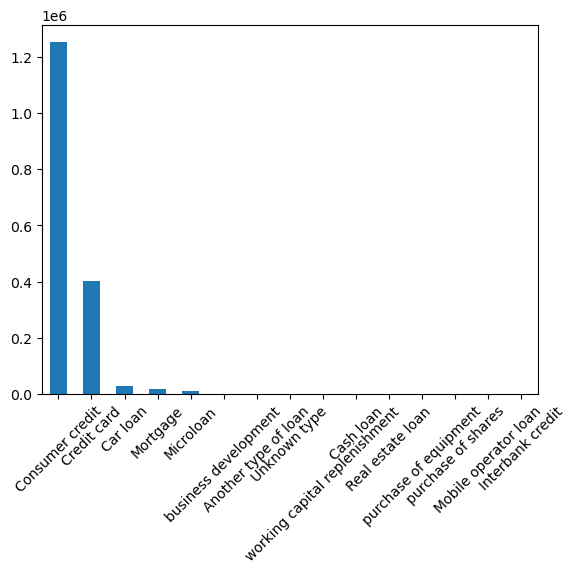

In [8]:
# 貸款類型(CT) 比例
br_df['CT'].value_counts().plot(kind='bar',rot=45)

<Axes: xlabel='mean', ylabel='CT'>

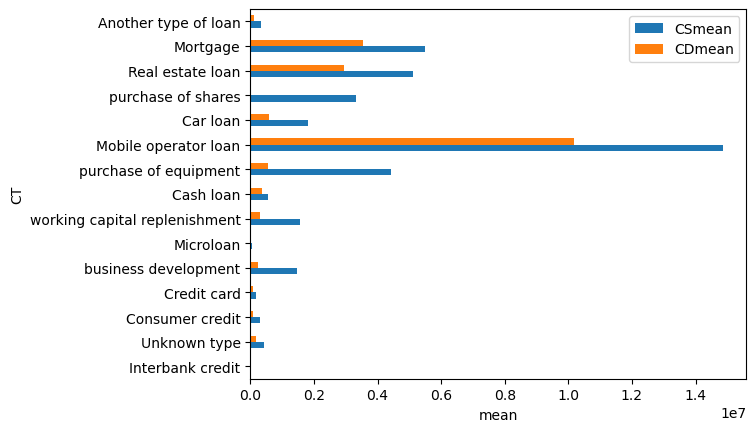

In [16]:
# df2['CT'].value_counts().plot(kind='bar')
CTdf = br_df.iloc[:,2:-1].groupby('CT')
CTMeandf = pd.DataFrame(columns=['CT','CDmean', 'CSmean', 'annuitymean'])
tempList = []
for i in loanType:
    # print(i,'的各項平均')
    tempList.append(i)
    for j in ['CD', 'CS', 'annuity']:
        tempList.append(round(np.mean(CTdf.get_group(i)[j]),2))
        # print(f'{j}的平均值: {np.mean(CTdf.get_group(i)[j])}')
tempArray = np.array(tempList).reshape(-1,4)

for i in range(len(tempArray.tolist())):
    CTMeandf.loc[len(CTMeandf)] = tempArray.tolist()[i]

# 貸款類型(CT) 在各欄位的平均表現
for i in ['CT','CDmean', 'CSmean', 'annuitymean']:
    if i == 'CT':
        CTMeandf[i] = CTMeandf[i]
    else:
        CTMeandf[i]  = pd.to_numeric(CTMeandf[i] ,errors='coerce')

# 有貸款類型的值不能計算平均，在此補 0
CTMeandf = CTMeandf.fillna(0.0)

values = br_df['CT'].value_counts(dropna=False).keys().tolist()
counts = br_df['CT'].value_counts(dropna=False).tolist()
value_dict = dict(zip(values, counts))

tempList = []
for i in range(len(CTMeandf['CT'])):
    tempList.append(value_dict[CTMeandf['CT'][i]])

CTMeandf['samples'] = tempList

tempList = []
for i in range(len(CTMeandf['samples'])):
    n = round(CTMeandf['samples'][i]/(CTMeandf['samples'].sum()),3)
    tempList.append(n)
CTMeandf['percentage'] = tempList

CTMeandf.index = CTMeandf['CT']
del CTMeandf['CT']
# print(CTMeandf)
# CTMeandf.to_csv('./data/CTMean.csv')

## 各貸款類別的當前平均信用額度(CS) 與平均債務金額(CD)
CTMeandf[['CSmean', 'CDmean']].plot(kind='barh', xlabel='mean')

<Axes: xlabel='annuity_mean', ylabel='CT'>

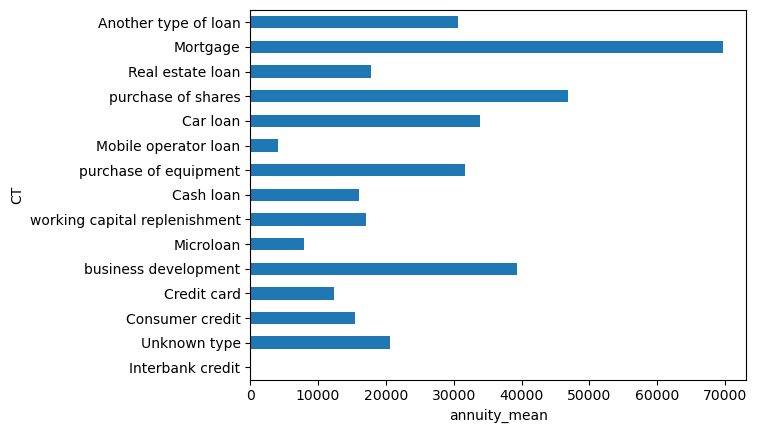

In [15]:
## 各貸款類別(CT) 的平均年金(annuity)
CTMeandf['annuitymean'].plot(kind='barh',xlabel='annuity_mean')

Consumer credit                  1251615
Credit card                       402195
Car loan                           27690
Mortgage                           18391
Microloan                          12413
business development                1975
Another type of loan                1017
Unknown type                         555
working capital replenishment        469
Cash loan                             56
Real estate loan                      27
purchase of equipment                 19
purchase of shares                     4
Mobile operator loan                   1
Interbank credit                       1
Name: CT, dtype: int64


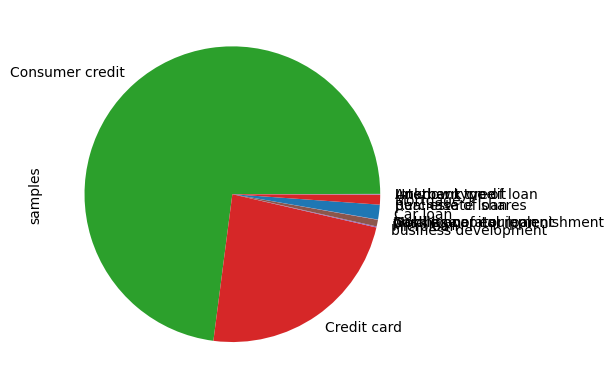

In [19]:
# 貸款類別(CT) 樣本數
CTMeandf['samples'].plot(kind= 'pie')
print(br_df['CT'].value_counts())

In [20]:
# 欄位相關性，當前信用額度(CS) 與債務金額(CD) 接近高度相關
corr = br_df.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\user\AppData\Local\Temp\ipykernel_14424\2927772561.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = br_df.corr()


,userID,SK_ID_BUREAU,CS,CD,annuity,average
userID,1.000000,0.000135,0.001179,-0.000790,-0.002727,-0.000144
SK_ID_BUREAU,0.000135,1.000000,0.007962,0.005732,0.001799,0.012179
CS,0.001179,0.007962,1.000000,0.683419,0.049146,-0.010626
CD,-0.000790,0.005732,0.683419,1.000000,0.025507,-0.005278
annuity,-0.002727,0.001799,0.049146,0.025507,1.000000,-0.001930
average,-0.000144,0.012179,-0.010626,-0.005278,-0.001930,1.000000


最小值: -5.0, 最大值: 1.0


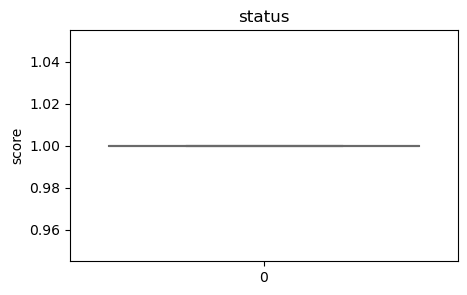

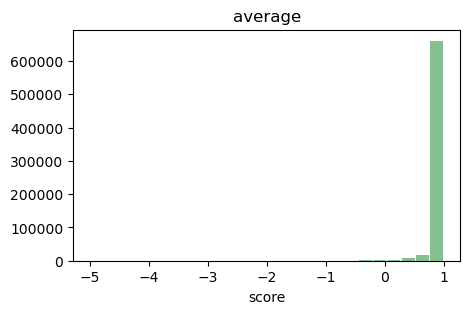

In [4]:
# 貸款評分狀況
print(f'最小值: {br_df["average"].min()}, 最大值: {br_df["average"].max()}')
# boxplot
plt.figure(figsize=(5, 3))
sns.boxplot(data= br_df['average'], orient='v', palette='Set3', showfliers=False)
plt.title('status')
plt.ylabel('score')
plt.show()
# histogram
br_df.hist(column='average', bins=25, grid=False, figsize=(5,3), color='#86bf91', zorder=2, rwidth=0.9)
plt.xlabel('score')
plt.show()

preprocess

In [5]:
# 移除不到 1 % 的貸款類別(CT) (視為噪音)
rmCols = [ 'Mobile operator loan','Real estate loan','Cash loan','Interbank credit','purchase of equipment','purchase of shares']
for i in rmCols:
    br_df.drop(br_df.loc[br_df['CT']==i].index, inplace=True)
br_df = br_df.reset_index()
print(f"刪除後一共 {len(set(br_df['CT']))} 個類別")

刪除後一共 9 個類別


In [6]:
# 查看各欄位第 99 百分位和 1 百分位數
for i in ['CD','CS', 'average', 'annuity']:
    print(f'{i} 在99分位數:{br_df[i].quantile(0.99)}, Max: {br_df[i].max()}, 在1分位數:{br_df[i].quantile(0.01)}, min: {br_df[i].min()}')
print()

# 界定極端值
print(f'債務金額超過一千萬共 {br_df[br_df["CD"] > 10000000].shape[0]} 筆')
print(f'信用額度超過兩千萬共 {br_df[br_df["CS"] > 20000000].shape[0]} 筆')
print(f'當月年金超過一千萬共 {br_df[br_df["annuity"] > 10000000].shape[0]} 筆')

CD 在99分位數:2259182.8386000055, Max: 170100000.0, 在1分位數:0.0, min: -4705600.32
CS 在99分位數:3691507.6799999834, Max: 585000000.0, 在1分位數:0.0, min: 0.0
average 在99分位數:1.0, Max: 1.0, 在1分位數:0.1428571428571428, min: -5.0
annuity 在99分位數:118454.85000000021, Max: 118453423.5, 在1分位數:0.0, min: 0.0

債務金額超過一千萬共 975 筆
信用額度超過兩千萬共 299 筆
當月年金超過一千萬共 24 筆


In [7]:
# 將債務金額(CD) 負值改成正值
br_df['CD'] = np.abs(br_df['CD'])
# print(br_df['CD'].min())

# 將極端值設為 NaN
for i in ['CD', 'CS', 'annuity']:
    if i == 'CD':
        br_df.loc[br_df[i] > 10000000 ,i] = np.nan
        br_df.loc[br_df[i] < 0, i] = 0
    elif i == 'CS':
        br_df.loc[br_df[i] > 20000000 ,i] = np.nan
    elif i == 'annuity':
        br_df.loc[br_df[i] > 10000000 ,i] = np.nan

print(br_df[['CD', 'CS', 'annuity', 'average']].describe())

                 CD            CS       annuity        average
count  1.457694e+06  1.716008e+06  4.895620e+05  694070.000000
mean   1.273508e+05  3.479523e+05  1.396244e+04       0.954128
std    5.072643e+05  8.190149e+05  9.334432e+04       0.251058
min    0.000000e+00  0.000000e+00  0.000000e+00      -5.000000
25%    0.000000e+00  5.129550e+04  0.000000e+00       1.000000
50%    0.000000e+00  1.254606e+05  0.000000e+00       1.000000
75%    3.976200e+04  3.150000e+05  1.350000e+04       1.000000
max    9.999716e+06  1.999800e+07  9.979880e+06       1.000000


In [8]:
# 根據貸款類別現有的值補 nan
for col in ['CD', 'CS', 'annuity']:
    # br_df[i]= br_df[i].fillna(br_df.groupby("CT")[i].transform('median')) # 以中位數補值
    br_df[col] = br_df.groupby('CT', sort=False, group_keys=False)[col].apply(lambda x: x.fillna(np.random.choice(x.unique())))
# print(br_df.isna().sum())

In [ ]:
# 以該筆貸款的貸款類別(CT)的最大最小值維上下界，隨機補給 nan 一個值 (無法跑出結果 !)
# for col in ['CS', 'CD', 'annuity']:
#     templist = []
#     for i in range(br_df.shape[0]):
#         minimum = br_df[br_df['CT'] == br_df.iloc[i]['CT']][col].min()
#         maximum = br_df[br_df['CT'] == br_df.iloc[i]['CT']][col].max()
#         templist.append(np.random.randint(low = minimum, high = maximum, size = 1))
#         temparray = np.array(templist)
#     br_df[str('random'+col)] = pd.Series(temparray)

# for col in ['CS', 'CD', 'annuity']:
#     br_df[col].fillna(value = br_df[str('random'+ col)], inplace = True)

# del br_df[['randomCD', 'randomCS', 'randomannuity']]

# print(br_df.isna().sum())

In [9]:
# average NaN 補 0，2，即視為沒紀錄
br_df['average'] = br_df['average'].fillna(0.0)
print(br_df.isna().sum())
# br_df.to_csv('./data/random_fillna.csv')

index           0
userID          0
SK_ID_BUREAU    0
CS              0
CD              0
CT              0
annuity         0
average         0
dtype: int64


In [10]:
# 賦予物理意義，eta: 7 mins
perUser = br_df.groupby(['userID'])
userList = list(set(br_df['userID']))

# 當月所需支付的年金總額
userSumAnn = []
# 信用額度使用率
userCD_CS_ratio = []
# 還款狀況
userStatus = []

for i in userList:
    userSumAnn.append(np.sum(perUser.get_group(i)['annuity']))
    userCD_CS_ratio.append(np.sum(perUser.get_group(i)['CD'])/np.sum(perUser.get_group(i)['CS']))
    userStatus.append(np.average(perUser.get_group(i)['average']))

C:\Users\user\AppData\Local\Temp\ipykernel_3836\3175902635.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  userCD_CS_ratio.append(np.sum(perUser.get_group(i)['CD'])/np.sum(perUser.get_group(i)['CS']))
C:\Users\user\AppData\Local\Temp\ipykernel_3836\3175902635.py:15: RuntimeWarning: invalid value encountered in double_scalars
  userCD_CS_ratio.append(np.sum(perUser.get_group(i)['CD'])/np.sum(perUser.get_group(i)['CS']))


In [43]:
# 最終每位 User 的 df
final_df = pd.DataFrame(
     {'SK_ID_CURR': userList,'CDCS_ratio': userCD_CS_ratio, 'annuity': userSumAnn, 'status': userStatus})
# print(final_df.iloc[:, 1:].describe())

# 有 1074 人沒有信用額度，即之前是小白，現在卻開始貸款
print(final_df.isna().sum())
# 將信用額度使用率 nan, inf 補 0 ，即此人的過往聯徵是小白
final_df['CDCS_ratio'].fillna(0.0, inplace = True)
final_df[np.isinf(final_df['CDCS_ratio'])] = 0
print()
print(final_df.isna().sum())

final_df.to_csv('./data/bureau_final.csv')

SK_ID_CURR       0
CDCS_ratio    1074
annuity          0
status           0
dtype: int64

SK_ID_CURR    0
CDCS_ratio    0
annuity       0
status        0
dtype: int64


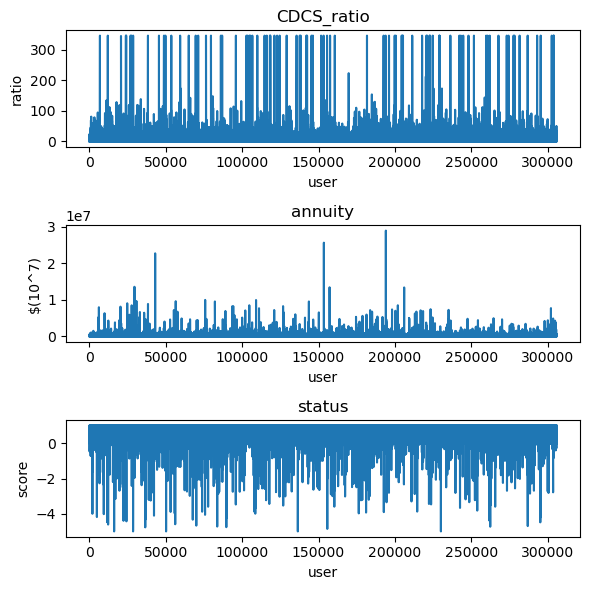

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('./data/bureau_final.csv')

plt.figure(figsize=(6, 6))
plt.subplot(3, 1, 1)
plt.gca().set_title('CDCS_ratio')
plt.gca().set_ylabel('ratio')
plt.gca().set_xlabel('user')
plt.plot(np.array(df['CDCS_ratio']))
plt.subplot(3, 1, 2)
plt.gca().set_title('annuity')
plt.gca().set_ylabel('$(10^7)')
plt.gca().set_xlabel('user')
plt.plot(np.array(df['annuity']))
plt.subplot(3, 1, 3)
plt.gca().set_title('status')
plt.gca().set_ylabel('score')
plt.gca().set_xlabel('user')
plt.plot(np.array(df['status']))
plt.tight_layout()

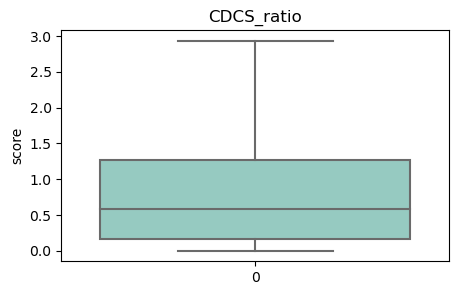

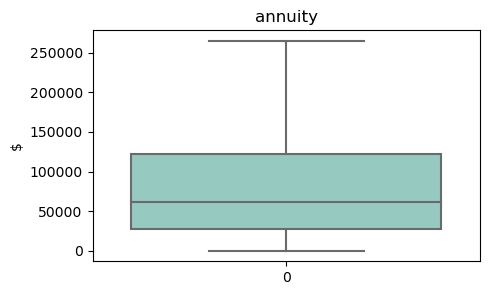

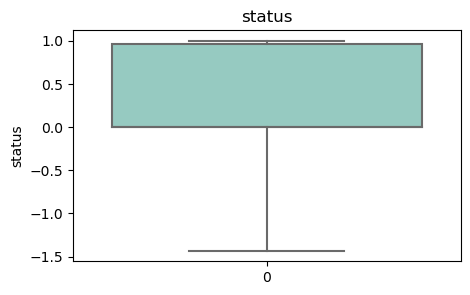

In [2]:
plt.figure(figsize=(5, 3))
sns.boxplot(data= df['CDCS_ratio'], orient='v', palette='Set3', showfliers=False)
plt.title('CDCS_ratio')
plt.ylabel('score')
plt.show()

plt.figure(figsize=(5, 3))
sns.boxplot(data= df['annuity'], orient='v', palette='Set3', showfliers=False)
plt.title('annuity')
plt.ylabel('$')
plt.show()

plt.figure(figsize=(5, 3))
sns.boxplot(data= df['status'], orient='v', palette='Set3', showfliers=False)
plt.title('status')
plt.ylabel('status')
plt.show()

In [7]:
# 信用額度使用率: 越高超過一理論上表示刷到爆掉，低信用
temp = df['CDCS_ratio'].unique()
temp = np.sort(temp)
temp = temp[::-1]
# print(f'信用額度使用率前五大值: {temp[:5]}')
print('=================信用額度使用率極端值=================')
print(f'Q1:{df["CDCS_ratio"].quantile(0.25)}, Q3: {df["CDCS_ratio"].quantile(0.75)}')
oIQR = df["CDCS_ratio"].quantile(0.75) - df["CDCS_ratio"].quantile(0.25)
print(f'Outlier 上下界: [{df["CDCS_ratio"].quantile(0.25)-1.5*oIQR},{df["CDCS_ratio"].quantile(0.75)+1.5*oIQR}]')
nOutliers = df.loc[df["CDCS_ratio"]>df["CDCS_ratio"].quantile(0.75)+1.5*oIQR].shape[0] + df.loc[df["CDCS_ratio"]<df["CDCS_ratio"].quantile(0.25)-1.5*oIQR].shape[0]
print(f'1.5 IQR 下的極端值共有: {nOutliers} 筆')
print()
print('=================年金極端值=================')
print(f'Q1:{df["annuity"].quantile(0.25)}, Q3: {df["annuity"].quantile(0.75)}')
oIQR = df["annuity"].quantile(0.75) - df["annuity"].quantile(0.25)
print(f'Outlier 上下界: [{df["annuity"].quantile(0.25)-1.5*oIQR},{df["annuity"].quantile(0.75)+1.5*oIQR}]')
nOutliers = df.loc[df["annuity"]>df["annuity"].quantile(0.75)+1.5*oIQR].shape[0] + df.loc[df["annuity"]<df["annuity"].quantile(0.25)-1.5*oIQR].shape[0]
print(f'1.5 IQR 下的極端值共有: {nOutliers} 筆')
print()
print('=================信用評分極端值=================')
print(f'Q1:{df["status"].quantile(0.25)}, Q3: {df["status"].quantile(0.75)}')
oIQR = df["status"].quantile(0.75) - df["status"].quantile(0.25)
print(f'Outlier 上下界: [{df["status"].quantile(0.25)-1.5*oIQR},{df["status"].quantile(0.75)+1.5*oIQR}]')
nOutliers = df.loc[df["status"]>df["status"].quantile(0.75)+1.5*oIQR].shape[0] + df.loc[df["status"]<df["status"].quantile(0.25)-1.5*oIQR].shape[0]
print(f'1.5 IQR 下的極端值共有: {nOutliers} 筆')

tempList = []
tempList1 = []
tempList2 = []
for i in ['CDCS_ratio', 'annuity', 'status']:
    temp = df.loc[df[i]>df[i].quantile(0.75)+1.5*(df[i].quantile(0.75) - df[i].quantile(0.25))]['SK_ID_CURR'].to_list()
    temp1 = df.loc[df[i]<df[i].quantile(0.25)-1.5*(df[i].quantile(0.75) - df[i].quantile(0.25))]['SK_ID_CURR'].to_list()
    if i == 'CDCS_ratio':
        tempList = temp + temp1
    elif i == 'annuity':
        tempList1 = temp + temp1
    else:
        tempList2 = temp + temp1
olList = tempList + tempList1 + tempList2
print()
print(f'總共有 {len(set(olList))} 人算極端值')

=================信用額度使用率極端值=================
Q1:0.16107747182301968, Q3: 1.2700306822218264
Outlier 上下界: [-1.5023523437751904,2.9334604978200365]
1.5 IQR 下的極端值共有: 35360 筆

=================年金極端值=================
Q1:27881.6625, Q3: 122729.85
Outlier 上下界: [-114390.61875,265002.13125]
1.5 IQR 下的極端值共有: 17275 筆

=================信用評分極端值=================
Q1:0.0, Q3: 0.9583333333333334
Outlier 上下界: [-1.4375,2.3958333333333335]
1.5 IQR 下的極端值共有: 230 筆

總共有 52116 人算極端值
